In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
import joblib

# Step 1: Load CSV file
data = pd.read_csv('/content/FINALLY_PUSHUP.csv')

# Step 2: Separate keypoints and labels
keypoints = data.iloc[:, 1:89].values  # Skip the first column (frame name) and take the next 88 columns
correct_label = data['pose-label'].values  # Binary labels: 0 (incorrect), 1 (correct)
error_type = data['error-label'].fillna('None').values  # Error types: None, Too-high-plank, Too-low-plank

# Step 3: Normalize keypoints (Min-Max Scaling)
scaler = MinMaxScaler()
keypoints = scaler.fit_transform(keypoints)

# Step 4: Reshape keypoints to (88, 1) for CNN input
keypoints = keypoints.reshape(-1, 88, 1)

# Step 5: Convert Error Type labels
encoder = LabelEncoder()
error_type_encoded = encoder.fit_transform(error_type)  # Encode error types as integers
error_type_categorical = to_categorical(error_type_encoded)  # One-hot encode for categorical model

# Step 6: Split data into training and testing sets
X_train, X_test, y_train_correct, y_test_correct, y_train_error, y_test_error = train_test_split(
    keypoints, correct_label, error_type_categorical, test_size=0.2, random_state=42
)

# Print data shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train_correct shape: {y_train_correct.shape}")
print(f"y_train_error shape: {y_train_error.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test_correct shape: {y_test_correct.shape}")
print(f"y_test_error shape: {y_test_error.shape}")


X_train shape: (840, 88, 1)
y_train_correct shape: (840,)
y_train_error shape: (840, 3)
X_test shape: (211, 88, 1)
y_test_correct shape: (211,)
y_test_error shape: (211, 3)


CNN

In [2]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_correct_incorrect():
    model = models.Sequential([
        layers.Input(shape=(88, 1)),  # 88 keypoints as input
        layers.Conv1D(32, kernel_size=3, activation='relu'),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification output
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Step 1: Build the model
model_1 = build_cnn_correct_incorrect()

# Step 3: Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_1 = model_1.fit(
    X_train, y_train_correct,
    validation_data=(X_test, y_test_correct),
    epochs=1000, batch_size=32, callbacks=[early_stopping]
)

model_1.save('/content/cnn_pose-label.keras')

Epoch 1/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6346 - loss: 0.6207 - val_accuracy: 0.7204 - val_loss: 0.5653
Epoch 2/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7437 - loss: 0.5439 - val_accuracy: 0.7536 - val_loss: 0.5105
Epoch 3/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7442 - loss: 0.4966 - val_accuracy: 0.7867 - val_loss: 0.4844
Epoch 4/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7964 - loss: 0.4503 - val_accuracy: 0.7915 - val_loss: 0.4591
Epoch 5/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8290 - loss: 0.4301 - val_accuracy: 0.8246 - val_loss: 0.3764
Epoch 6/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8300 - loss: 0.3704 - val_accuracy: 0.7820 - val_loss: 0.4067
Epoch 7/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8390 - loss: 0.3415 - val_accuracy: 0.8768 - val_loss: 0.3193
Epoch 8/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8761 - loss: 0.3170 - val_accu

In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.metrics import AUC

# Model 1 predictions
y_pred_model_1 = model_1.predict(X_test)  # Assuming 'model_1' is the trained model
y_pred_model_1 = (y_pred_model_1 > 0.5)  # If binary classification, otherwise use softmax for multi-class

# Accuracy
accuracy = accuracy_score(y_test_correct, y_pred_model_1)

# Precision
precision = precision_score(y_test_correct, y_pred_model_1)

# Recall
recall = recall_score(y_test_correct, y_pred_model_1)

# F1 Score
f1 = f1_score(y_test_correct, y_pred_model_1)

print(f"Model CNN Evaluation:\n"
      f"Accuracy: {accuracy}\n"
      f"Precision: {precision}\n"
      f"Recall: {recall}\n"
      f"F1 Score: {f1}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Model CNN Evaluation:
Accuracy: 0.9478672985781991
Precision: 0.9594594594594594
Recall: 0.9659863945578231
F1 Score: 0.9627118644067797


In [4]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Updated build model function
def build_cnn_error_classification():
    model = models.Sequential([
        layers.Input(shape=(88, 1)),  # 88 keypoints as input
        layers.Conv1D(32, kernel_size=3, activation='relu'),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(3, activation='softmax')  # Multi-class classification output (3 classes)
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Filter only incorrect samples for training Model 2
X_train_incorrect = X_train[y_train_correct == 0]
X_test_incorrect = X_test[y_test_correct == 0]
y_train_error_incorrect = y_train_error[y_train_correct == 0]
y_test_error_incorrect = y_test_error[y_test_correct == 0]

# Check and reshape if necessary
print(f"Shape of y_train_error_incorrect before one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect before one-hot encoding: {y_test_error_incorrect.shape}")

# Only apply one-hot encoding if they are not already encoded
if len(y_train_error_incorrect.shape) == 1:
    y_train_error_incorrect = to_categorical(y_train_error_incorrect, num_classes=3)
    y_test_error_incorrect = to_categorical(y_test_error_incorrect, num_classes=3)

# Check shapes after one-hot encoding
print(f"Shape of y_train_error_incorrect after one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect after one-hot encoding: {y_test_error_incorrect.shape}")

# Train the model
model_2 = build_cnn_error_classification()

history_2 = model_2.fit(
    X_train_incorrect, y_train_error_incorrect,
    validation_data=(X_test_incorrect, y_test_error_incorrect),
    epochs=50, batch_size=32
)

# Save the model
model_2.save('/content/cnn_error-label.keras')

Shape of y_train_error_incorrect before one-hot encoding: (294, 3)
Shape of y_test_error_incorrect before one-hot encoding: (64, 3)
Shape of y_train_error_incorrect after one-hot encoding: (294, 3)
Shape of y_test_error_incorrect after one-hot encoding: (64, 3)
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6241 - loss: 0.8547 - val_accuracy: 0.5469 - val_loss: 0.6603
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6826 - loss: 0.6356 - val_accuracy: 0.7344 - val_loss: 0.5821
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7406 - loss: 0.5897 - val_accuracy: 0.6094 - val_loss: 0.6025
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6930 - loss: 0.5587 - val_accuracy: 0.8750 - val_loss: 0.4535
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8063 - loss: 0.4840 - val_accuracy: 0.8906 - val_loss: 0.3997
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8219 - loss: 0.4413 - val_accuracy: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 


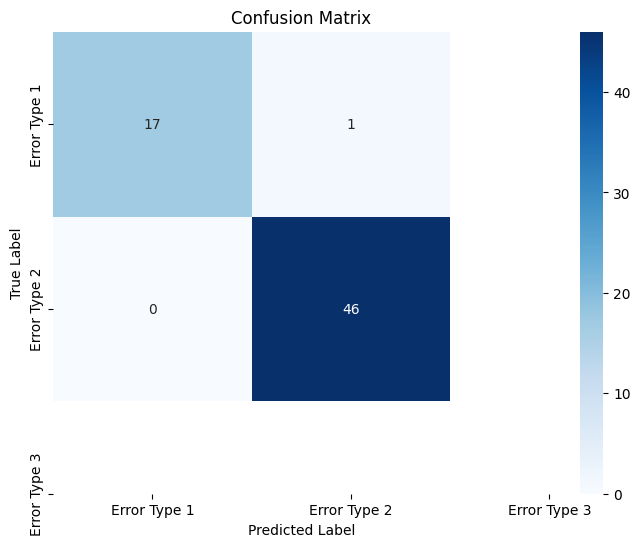

Model CNN Evaluation:
F1 Score for Error Type 1: 0.0
F1 Score for Error Type 2: 0.9714285714285714
F1 Score for Error Type 3: 0.989247311827957


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [5]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert true labels to class indices if they are one-hot encoded
y_test_error_incorrect_class = np.argmax(y_test_error_incorrect, axis=1)

# Model 2 predictions (assuming the model outputs class probabilities)
y_pred_model_2 = model_2.predict(X_test_incorrect)  # Your model's predictions
y_pred_model_2 = np.argmax(y_pred_model_2, axis=1)  # Convert predictions to class indices

# Confusion Matrix
cm = confusion_matrix(y_test_error_incorrect_class, y_pred_model_2)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'],
            yticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# F1-score for each error type (class)
f1_error_1 = f1_score(y_test_error_incorrect_class, y_pred_model_2, labels=[0], average='micro')  # Error Type 1
f1_error_2 = f1_score(y_test_error_incorrect_class, y_pred_model_2, labels=[1], average='micro')  # Error Type 2
f1_error_3 = f1_score(y_test_error_incorrect_class, y_pred_model_2, labels=[2], average='micro')  # Error Type 3

print(f"Model CNN Evaluation:\n"
      f"F1 Score for Error Type 1: {f1_error_1}\n"
      f"F1 Score for Error Type 2: {f1_error_2}\n"
      f"F1 Score for Error Type 3: {f1_error_3}")

CNN with Attention

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_with_attention_correct_incorrect():
    inputs = layers.Input(shape=(88, 1))
    x = layers.Conv1D(32, kernel_size=3, activation='relu')(inputs)
    x = layers.Conv1D(64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    attention = layers.Attention()([x, x])  # Self-attention
    x = layers.Flatten()(attention)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Step 1: Build the model
model_3 = build_cnn_with_attention_correct_incorrect()

# Step 3: Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_3 = model_3.fit(
    X_train, y_train_correct,
    validation_data=(X_test, y_test_correct),
    epochs=1000, batch_size=32, callbacks=[early_stopping]
)

model_3.save('/content/cnn-with-attention_pose-label.keras')

Epoch 1/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5943 - loss: 0.6683 - val_accuracy: 0.6967 - val_loss: 0.5986
Epoch 2/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6461 - loss: 0.6362 - val_accuracy: 0.7156 - val_loss: 0.6123
Epoch 3/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6930 - loss: 0.6158 - val_accuracy: 0.7204 - val_loss: 0.5708
Epoch 4/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7166 - loss: 0.5834 - val_accuracy: 0.7346 - val_loss: 0.5785
Epoch 5/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6988 - loss: 0.5938 - val_accuracy: 0.7346 - val_loss: 0.5530
Epoch 6/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7089 - loss: 0.5574 - val_accuracy: 0.5687 - val_loss: 0.6604
Epoch 7/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6547 - loss: 0.5865 - val_accuracy: 0.7346 - val_loss: 0.5079
Epoch 8/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7387 - loss: 0.5272 - val_accu

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.metrics import AUC

# Model 1 predictions
y_pred_model_3 = model_3.predict(X_test)  # Assuming 'model_1' is the trained model
y_pred_model_3 = (y_pred_model_3 > 0.5)  # If binary classification, otherwise use softmax for multi-class

# Accuracy
accuracy = accuracy_score(y_test_correct, y_pred_model_3)

# Precision
precision = precision_score(y_test_correct, y_pred_model_3)

# Recall
recall = recall_score(y_test_correct, y_pred_model_3)

# F1 Score
f1 = f1_score(y_test_correct, y_pred_model_3)

print(f"Model CNN with Attention Evaluation:\n"
      f"Accuracy: {accuracy}\n"
      f"Precision: {precision}\n"
      f"Recall: {recall}\n"
      f"F1 Score: {f1}")


1/7 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Model CNN with Attention Evaluation:
Accuracy: 0.943127962085308
Precision: 0.972027972027972
Recall: 0.9455782312925171
F1 Score: 0.9586206896551724


In [8]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Updated build model function
def build_cnn_with_attention_error_classification():
    inputs = layers.Input(shape=(88, 1))
    x = layers.Conv1D(32, kernel_size=3, activation='relu')(inputs)
    x = layers.Conv1D(64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    attention = layers.Attention()([x, x])  # Self-attention
    x = layers.Flatten()(attention)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Filter only incorrect samples for training Model 2
X_train_incorrect = X_train[y_train_correct == 0]
X_test_incorrect = X_test[y_test_correct == 0]
y_train_error_incorrect = y_train_error[y_train_correct == 0]
y_test_error_incorrect = y_test_error[y_test_correct == 0]

# Check and reshape if necessary
print(f"Shape of y_train_error_incorrect before one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect before one-hot encoding: {y_test_error_incorrect.shape}")

# Only apply one-hot encoding if they are not already encoded
if len(y_train_error_incorrect.shape) == 1:
    y_train_error_incorrect = to_categorical(y_train_error_incorrect, num_classes=3)
    y_test_error_incorrect = to_categorical(y_test_error_incorrect, num_classes=3)

# Check shapes after one-hot encoding
print(f"Shape of y_train_error_incorrect after one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect after one-hot encoding: {y_test_error_incorrect.shape}")

# Train the model
model_4 = build_cnn_error_classification()

history_4 = model_4.fit(
    X_train_incorrect, y_train_error_incorrect,
    validation_data=(X_test_incorrect, y_test_error_incorrect),
    epochs=50, batch_size=32
)

# Save the model
model_4.save('/content/cnn-with-attention_error-label.keras')


Shape of y_train_error_incorrect before one-hot encoding: (294, 3)
Shape of y_test_error_incorrect before one-hot encoding: (64, 3)
Shape of y_train_error_incorrect after one-hot encoding: (294, 3)
Shape of y_test_error_incorrect after one-hot encoding: (64, 3)
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.6222 - loss: 0.8359 - val_accuracy: 0.7969 - val_loss: 0.5631
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8143 - loss: 0.5635 - val_accuracy: 0.7500 - val_loss: 0.5346
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8113 - loss: 0.4816 - val_accuracy: 0.8125 - val_loss: 0.4595
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8060 - loss: 0.4568 - val_accuracy: 0.8438 - val_loss: 0.3566
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9052 - loss: 0.3330 - val_accuracy: 0.9219 - val_loss: 0.2844
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8381 - loss: 0.3445 - val_accuracy: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


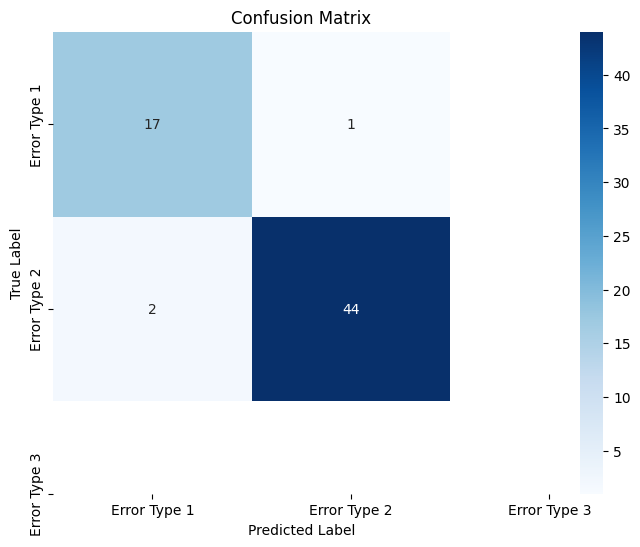

Model CNN with Attention Evaluation:
F1 Score for Error Type 1: 0.0
F1 Score for Error Type 2: 0.918918918918919
F1 Score for Error Type 3: 0.967032967032967


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert true labels to class indices if they are one-hot encoded
y_test_error_incorrect_class = np.argmax(y_test_error_incorrect, axis=1)

# Model 2 predictions (assuming the model outputs class probabilities)
y_pred_model_4 = model_4.predict(X_test_incorrect)  # Your model's predictions
y_pred_model_4 = np.argmax(y_pred_model_4, axis=1)  # Convert predictions to class indices

# Confusion Matrix
cm = confusion_matrix(y_test_error_incorrect_class, y_pred_model_4)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'],
            yticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# F1-score for each error type (class)
f1_error_1 = f1_score(y_test_error_incorrect_class, y_pred_model_4, labels=[0], average='micro')  # Error Type 1
f1_error_2 = f1_score(y_test_error_incorrect_class, y_pred_model_4, labels=[1], average='micro')  # Error Type 2
f1_error_3 = f1_score(y_test_error_incorrect_class, y_pred_model_4, labels=[2], average='micro')  # Error Type 3

print(f"Model CNN with Attention Evaluation:\n"
      f"F1 Score for Error Type 1: {f1_error_1}\n"
      f"F1 Score for Error Type 2: {f1_error_2}\n"
      f"F1 Score for Error Type 3: {f1_error_3}")

VGG

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers, models

def build_vgg_correct_incorrect():
    model = models.Sequential([
        layers.Input(shape=(88, 1)),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Step 1: Build the model
model_5 = build_vgg_correct_incorrect()

# Step 3: Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_5 = model_5.fit(
    X_train, y_train_correct,
    validation_data=(X_test, y_test_correct),
    epochs=1000, batch_size=32, callbacks=[early_stopping]
)

model_5.save('/content/vgg_pose-label.keras')

Epoch 1/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6081 - loss: 0.6419 - val_accuracy: 0.7156 - val_loss: 0.5657
Epoch 2/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7330 - loss: 0.5508 - val_accuracy: 0.7393 - val_loss: 0.4949
Epoch 3/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7692 - loss: 0.4824 - val_accuracy: 0.8341 - val_loss: 0.3232
Epoch 4/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8316 - loss: 0.3372 - val_accuracy: 0.7915 - val_loss: 0.4202
Epoch 5/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8293 - loss: 0.3717 - val_accuracy: 0.9005 - val_loss: 0.2579
Epoch 6/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8739 - loss: 0.2948 - val_accuracy: 0.8815 - val_loss: 0.2756
Epoch 7/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8703 - loss: 0.2666 - val_accuracy: 0.8768 - val_loss: 0.2652
Epoch 8/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8900 - loss: 0.2368 - val_accu

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.metrics import AUC

# Model 1 predictions
y_pred_model_5 = model_5.predict(X_test)  # Assuming 'model_1' is the trained model
y_pred_model_5 = (y_pred_model_5 > 0.5)  # If binary classification, otherwise use softmax for multi-class

# Accuracy
accuracy = accuracy_score(y_test_correct, y_pred_model_5)

# Precision
precision = precision_score(y_test_correct, y_pred_model_5)

# Recall
recall = recall_score(y_test_correct, y_pred_model_5)

# F1 Score
f1 = f1_score(y_test_correct, y_pred_model_5)

print(f"Model VGG Evaluation:\n"
      f"Accuracy: {accuracy}\n"
      f"Precision: {precision}\n"
      f"Recall: {recall}\n"
      f"F1 Score: {f1}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Model VGG Evaluation:
Accuracy: 0.957345971563981
Precision: 0.9662162162162162
Recall: 0.9727891156462585
F1 Score: 0.9694915254237289


In [12]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Updated build model function
def build_vgg_error_classification():
    model = models.Sequential([
        layers.Input(shape=(88, 1)),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Filter only incorrect samples for training Model 2
X_train_incorrect = X_train[y_train_correct == 0]
X_test_incorrect = X_test[y_test_correct == 0]
y_train_error_incorrect = y_train_error[y_train_correct == 0]
y_test_error_incorrect = y_test_error[y_test_correct == 0]

# Check and reshape if necessary
print(f"Shape of y_train_error_incorrect before one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect before one-hot encoding: {y_test_error_incorrect.shape}")

# Only apply one-hot encoding if they are not already encoded
if len(y_train_error_incorrect.shape) == 1:
    y_train_error_incorrect = to_categorical(y_train_error_incorrect, num_classes=3)
    y_test_error_incorrect = to_categorical(y_test_error_incorrect, num_classes=3)

# Check shapes after one-hot encoding
print(f"Shape of y_train_error_incorrect after one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect after one-hot encoding: {y_test_error_incorrect.shape}")

# Train the model
model_6 = build_vgg_error_classification()

history_6 = model_6.fit(
    X_train_incorrect, y_train_error_incorrect,
    validation_data=(X_test_incorrect, y_test_error_incorrect),
    epochs=50, batch_size=32
)

# Save the model
model_6.save('/content/vgg_error-label.keras')


Shape of y_train_error_incorrect before one-hot encoding: (294, 3)
Shape of y_test_error_incorrect before one-hot encoding: (64, 3)
Shape of y_train_error_incorrect after one-hot encoding: (294, 3)
Shape of y_test_error_incorrect after one-hot encoding: (64, 3)
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.5233 - loss: 0.8762 - val_accuracy: 0.7188 - val_loss: 0.5261
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6334 - loss: 0.6423 - val_accuracy: 0.8906 - val_loss: 0.4886
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7635 - loss: 0.5680 - val_accuracy: 0.7188 - val_loss: 0.4546
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7070 - loss: 0.5558 - val_accuracy: 0.9062 - val_loss: 0.3752
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8550 - loss: 0.3645 - val_accuracy: 0.8906 - val_loss: 0.2175
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9162 - loss: 0.2219 - val_accuracy: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


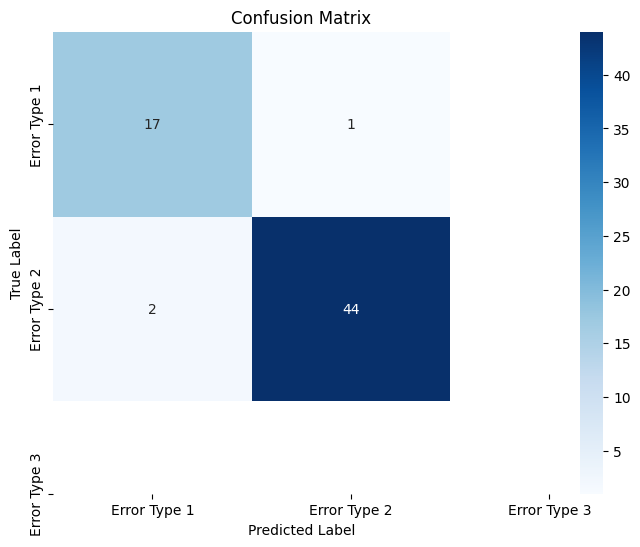

Model VGG Evaluation:
F1 Score for Error Type 1: 0.0
F1 Score for Error Type 2: 0.918918918918919
F1 Score for Error Type 3: 0.967032967032967


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert true labels to class indices if they are one-hot encoded
y_test_error_incorrect_class = np.argmax(y_test_error_incorrect, axis=1)

# Model 2 predictions (assuming the model outputs class probabilities)
y_pred_model_6 = model_6.predict(X_test_incorrect)  # Your model's predictions
y_pred_model_6 = np.argmax(y_pred_model_6, axis=1)  # Convert predictions to class indices

# Confusion Matrix
cm = confusion_matrix(y_test_error_incorrect_class, y_pred_model_6)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'],
            yticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# F1-score for each error type (class)
f1_error_1 = f1_score(y_test_error_incorrect_class, y_pred_model_6, labels=[0], average='micro')  # Error Type 1
f1_error_2 = f1_score(y_test_error_incorrect_class, y_pred_model_6, labels=[1], average='micro')  # Error Type 2
f1_error_3 = f1_score(y_test_error_incorrect_class, y_pred_model_6, labels=[2], average='micro')  # Error Type 3

print(f"Model VGG Evaluation:\n"
      f"F1 Score for Error Type 1: {f1_error_1}\n"
      f"F1 Score for Error Type 2: {f1_error_2}\n"
      f"F1 Score for Error Type 3: {f1_error_3}")

Transformer

In [14]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

def build_transformer_correct_incorrect():
    inputs = layers.Input(shape=(88, 1))

    # Pass through a dense layer before the attention layer
    x = layers.Dense(64, activation='relu')(inputs)

    # Add Multi-Head Attention layer
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)

    # Add a residual connection and layer normalization
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)

    # Apply Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Define and compile the model
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 1: Build the model
model_7 = build_transformer_correct_incorrect()

# Step 2: Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Step 3: Train the model
history_7 = model_7.fit(
    X_train, y_train_correct,
    validation_data=(X_test, y_test_correct),
    epochs=1000, batch_size=32, callbacks=[early_stopping]
)

# Save the trained model
model_7.save('/content/transformer_pose-label.keras')


Epoch 1/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6487 - loss: 0.6571 - val_accuracy: 0.6967 - val_loss: 0.6064
Epoch 2/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6480 - loss: 0.6468 - val_accuracy: 0.6967 - val_loss: 0.5942
Epoch 3/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6933 - loss: 0.6220 - val_accuracy: 0.7346 - val_loss: 0.5930
Epoch 4/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.6917 - loss: 0.6266 - val_accuracy: 0.7109 - val_loss: 0.6504
Epoch 5/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7095 - loss: 0.6166 - val_accuracy: 0.7346 - val_loss: 0.5833
Epoch 6/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7169 - loss: 0.6116 - val_accuracy: 0.7251 - val_loss: 0.5795
Epoch 7/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7099 - loss: 0.6046 - val_accuracy: 0.7299 - val_loss: 0.6041
Epoch 8/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6991 - loss: 0.6132 - val_accu

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.metrics import AUC

# Model 1 predictions
y_pred_model_7 = model_7.predict(X_test)  # Assuming 'model_1' is the trained model
y_pred_model_7 = (y_pred_model_7 > 0.5)  # If binary classification, otherwise use softmax for multi-class

# Accuracy
accuracy = accuracy_score(y_test_correct, y_pred_model_7)

# Precision
precision = precision_score(y_test_correct, y_pred_model_7)

# Recall
recall = recall_score(y_test_correct, y_pred_model_7)

# F1 Score
f1 = f1_score(y_test_correct, y_pred_model_7)

print(f"Model Transformer Evaluation:\n"
      f"Accuracy: {accuracy}\n"
      f"Precision: {precision}\n"
      f"Recall: {recall}\n"
      f"F1 Score: {f1}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Model Transformer Evaluation:
Accuracy: 0.7535545023696683
Precision: 0.7987421383647799
Recall: 0.8639455782312925
F1 Score: 0.8300653594771242


In [18]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

def build_transformer_error_classification():
    inputs = layers.Input(shape=(88, 1))

    # Pass through a dense layer before the attention layer
    x = layers.Dense(64, activation='relu')(inputs)

    # Add Multi-Head Attention layer
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)

    # Add a residual connection and layer normalization
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)

    # Apply Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(3, activation='softmax')(x)  # Adjust to 3 output classes

    # Define and compile the model
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Filter only incorrect samples for training Model 2
X_train_incorrect = X_train[y_train_correct == 0]
X_test_incorrect = X_test[y_test_correct == 0]
y_train_error_incorrect = y_train_error[y_train_correct == 0]
y_test_error_incorrect = y_test_error[y_test_correct == 0]

# Check and reshape if necessary
print(f"Shape of y_train_error_incorrect before one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect before one-hot encoding: {y_test_error_incorrect.shape}")

# Only apply one-hot encoding if they are not already encoded
if len(y_train_error_incorrect.shape) == 1:
    y_train_error_incorrect = to_categorical(y_train_error_incorrect, num_classes=3)
    y_test_error_incorrect = to_categorical(y_test_error_incorrect, num_classes=3)

# Check shapes after one-hot encoding
print(f"Shape of y_train_error_incorrect after one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect after one-hot encoding: {y_test_error_incorrect.shape}")

# Train the model
model_8 = build_transformer_error_classification()

# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history_8 = model_8.fit(
    X_train_incorrect, y_train_error_incorrect,
    validation_data=(X_test_incorrect, y_test_error_incorrect),
    epochs=50, batch_size=32
)

# Save the model
model_8.save('/content/transformer_error-label.keras')


Shape of y_train_error_incorrect before one-hot encoding: (294, 3)
Shape of y_test_error_incorrect before one-hot encoding: (64, 3)
Shape of y_train_error_incorrect after one-hot encoding: (294, 3)
Shape of y_test_error_incorrect after one-hot encoding: (64, 3)
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5501 - loss: 0.8157 - val_accuracy: 0.7188 - val_loss: 0.6127
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5811 - loss: 0.6727 - val_accuracy: 0.7188 - val_loss: 0.5841
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6289 - loss: 0.6723 - val_accuracy: 0.7188 - val_loss: 0.5953
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6359 - loss: 0.6293 - val_accuracy: 0.3750 - val_loss: 0.8286
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4906 - loss: 0.7417 - val_accuracy: 0.7188 - val_loss: 0.5763
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5679 - loss: 0.6583 - val_accuracy: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step 


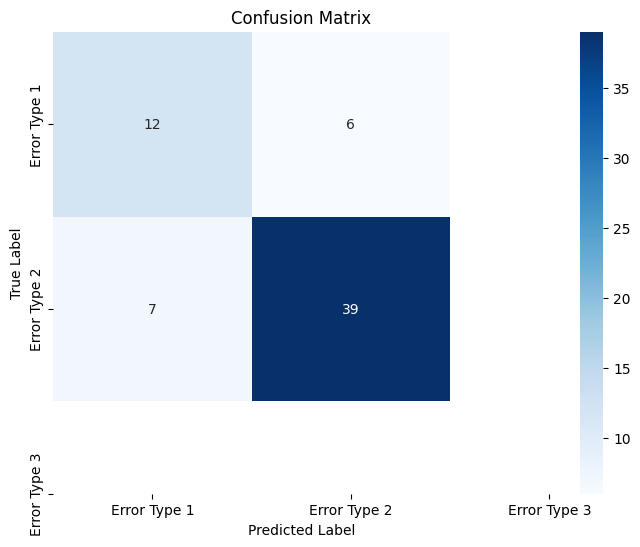

Model Transformer Evaluation:
F1 Score for Error Type 1: 0.0
F1 Score for Error Type 2: 0.6486486486486487
F1 Score for Error Type 3: 0.8571428571428571


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert true labels to class indices if they are one-hot encoded
y_test_error_incorrect_class = np.argmax(y_test_error_incorrect, axis=1)

# Model 2 predictions (assuming the model outputs class probabilities)
y_pred_model_8 = model_8.predict(X_test_incorrect)  # Your model's predictions
y_pred_model_8 = np.argmax(y_pred_model_8, axis=1)  # Convert predictions to class indices

# Confusion Matrix
cm = confusion_matrix(y_test_error_incorrect_class, y_pred_model_8)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'],
            yticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# F1-score for each error type (class)
f1_error_1 = f1_score(y_test_error_incorrect_class, y_pred_model_8, labels=[0], average='micro')  # Error Type 1
f1_error_2 = f1_score(y_test_error_incorrect_class, y_pred_model_8, labels=[1], average='micro')  # Error Type 2
f1_error_3 = f1_score(y_test_error_incorrect_class, y_pred_model_8, labels=[2], average='micro')  # Error Type 3

print(f"Model Transformer Evaluation:\n"
      f"F1 Score for Error Type 1: {f1_error_1}\n"
      f"F1 Score for Error Type 2: {f1_error_2}\n"
      f"F1 Score for Error Type 3: {f1_error_3}")